In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings 
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 25
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 12]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
#colors = cmap(np.linspace(0, 1, n)) #n: number of the lines you want to plot 
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['tic','datadate','industry_id','forward_excess_ret','ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda']]
industry_dummy = pd.get_dummies(features['industry_id'])
features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['forward_excess_ret'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

In [3]:
for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t



for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [4]:
feature_names=['ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda',10,15,20,25,30,35,40,45,50,55,60]
X = features_after[feature_names]
#X = sm.add_constant(X)
Y = features_after[['forward_excess_ret']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)

## Prediction

### Linear

In [5]:
#Linear
reg = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train)   
print(reg.alphas_)
print(reg.coef_)
print(reg.intercept_)

[1.0e-03 9.9e-04 9.8e-04 9.7e-04 9.6e-04 9.5e-04 9.4e-04 9.3e-04 9.2e-04
 9.1e-04 9.0e-04 8.9e-04 8.8e-04 8.7e-04 8.6e-04 8.5e-04 8.4e-04 8.3e-04
 8.2e-04 8.1e-04 8.0e-04 7.9e-04 7.8e-04 7.7e-04 7.6e-04 7.5e-04 7.4e-04
 7.3e-04 7.2e-04 7.1e-04 7.0e-04 6.9e-04 6.8e-04 6.7e-04 6.6e-04 6.5e-04
 6.4e-04 6.3e-04 6.2e-04 6.1e-04 6.0e-04 5.9e-04 5.8e-04 5.7e-04 5.6e-04
 5.5e-04 5.4e-04 5.3e-04 5.2e-04 5.1e-04 5.0e-04 4.9e-04 4.8e-04 4.7e-04
 4.6e-04 4.5e-04 4.4e-04 4.3e-04 4.2e-04 4.1e-04 4.0e-04 3.9e-04 3.8e-04
 3.7e-04 3.6e-04 3.5e-04 3.4e-04 3.3e-04 3.2e-04 3.1e-04 3.0e-04 2.9e-04
 2.8e-04 2.7e-04 2.6e-04 2.5e-04 2.4e-04 2.3e-04 2.2e-04 2.1e-04 2.0e-04
 1.9e-04 1.8e-04 1.7e-04 1.6e-04 1.5e-04 1.4e-04 1.3e-04 1.2e-04 1.1e-04
 1.0e-04 9.0e-05 8.0e-05 7.0e-05 6.0e-05 5.0e-05 4.0e-05 3.0e-05 2.0e-05
 1.0e-05]
[ 0.02598442  0.01301883 -0.00575027 -0.03257139 -0.04730033  0.08012465
 -0.60203502 -0.          0.09350115 -0.10179287  0.0177239   0.13037815
 -0.00424412  0.16954344  0.00138106 -0.1

### KNN

In [6]:
#KNN

for n in [2,3,4,5,6,7,8]:
    neigh = KNeighborsRegressor(n_neighbors=n)
    #neigh.fit(X_train,y_train)
    scores = cross_val_score(neigh, X_train,y_train, cv=5)
    print(n,np.mean(scores))

2 -0.5010384204757524
3 -0.33243379791066985
4 -0.2514948538341467
5 -0.1999391095261529
6 -0.1629049773254724
7 -0.137542936655489
8 -0.12355743937633394


### Random Forest

In [7]:
#random forest

for max_depth in [2,3,4,5,6,7]:
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
    scores = cross_val_score(regr, X_train,y_train, cv=5)
    print(max_depth,np.mean(scores))

2 -0.0008640087858114099
3 -0.001115361124667902
4 -0.001513577498287466
5 -0.0017461525406849755
6 -0.0026166156564013665
7 -0.0034032223932203287


### SVR

In [8]:
#SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline


SVR_m = SVR()
param_grid0 = {'C': [0.01, 0.1], 'epsilon':[0.2,0.3]}
grid_search0 = GridSearchCV(SVR_m, scoring = 'neg_mean_squared_error',param_grid = param_grid0, cv=5, return_train_score=True)

grid_search0.fit(X_train, y_train) 

print("Scores on training set:")
means = grid_search0.cv_results_['mean_test_score']
stds = grid_search0.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search0.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Scores on training set:
-59.583 (+/-2.734) for {'C': 0.01, 'epsilon': 0.2}
-59.586 (+/-2.737) for {'C': 0.01, 'epsilon': 0.3}
-59.650 (+/-2.716) for {'C': 0.1, 'epsilon': 0.2}
-59.645 (+/-2.710) for {'C': 0.1, 'epsilon': 0.3}


In [9]:
print(grid_search0.cv_results_) 
print(grid_search0.best_params_)

{'mean_fit_time': array([104.56317344, 103.35397372, 105.91893692, 104.90059919]), 'std_fit_time': array([0.81083327, 1.54815872, 1.82163635, 2.33547779]), 'mean_score_time': array([16.13956785, 16.6670979 , 16.18957071, 15.91089969]), 'std_score_time': array([0.29813951, 0.7948492 , 0.22199624, 0.15240719]), 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_epsilon': masked_array(data=[0.2, 0.3, 0.2, 0.3],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01, 'epsilon': 0.2}, {'C': 0.01, 'epsilon': 0.3}, {'C': 0.1, 'epsilon': 0.2}, {'C': 0.1, 'epsilon': 0.3}], 'split0_test_score': array([-57.15645934, -57.15767106, -57.24131627, -57.2430712 ]), 'split1_test_score': array([-59.91909325, -59.91865833, -59.94353537, -59.94553237]), 'split2_test_score': array([-59.50544436, -59.50847867, -59.62854904, -59.62100187]),

In [10]:
SVR_f = grid_search0.best_estimator_.fit(X_train, y_train)

y_hat0 = SVR_f.predict(X_test)
svm_score = SVR_f.score(X_test, y_test)
svm_score

0.0005738828583021771

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)

param_grid2 = {"criterion" : ["mse"],
              "max_depth" :   [2,3,4],
               'min_samples_split' : [2,5,10]
             }

grid_search3 = GridSearchCV(tree, param_grid=param_grid2,scoring='neg_mean_squared_error', cv=5, return_train_score = True)
grid_search3.fit(X_train, y_train) 

print("Scores on training set:")
means = grid_search3.cv_results_['mean_test_score']
stds = grid_search3.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(grid_search3.best_params_)

Scores on training set:
-59.673 (+/-2.683) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2}
-59.672 (+/-2.628) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 5}
-59.674 (+/-2.632) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 10}
-59.795 (+/-2.464) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 2}
-59.718 (+/-2.566) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 5}
-59.715 (+/-2.570) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 10}
-59.810 (+/-2.632) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 2}
-59.839 (+/-2.576) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 5}
-59.749 (+/-2.512) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 10}
{'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 5}


In [12]:
print(grid_search3.cv_results_) 
print(grid_search3.best_params_)

{'mean_fit_time': array([0.13191843, 0.14042244, 0.126125  , 0.21270013, 0.23241601,
       0.22460151, 0.25951676, 0.23406248, 0.23685427]), 'std_fit_time': array([0.01174311, 0.00757648, 0.00366452, 0.03023026, 0.02404635,
       0.04656171, 0.03426592, 0.00766384, 0.00365235]), 'mean_score_time': array([0.00785017, 0.0083962 , 0.0076262 , 0.01046677, 0.00955706,
       0.00903697, 0.00870667, 0.00733528, 0.00804667]), 'std_score_time': array([1.13459992e-03, 5.15194148e-04, 4.83797171e-04, 3.07212032e-03,
       1.14278811e-03, 1.80264841e-03, 1.16838729e-03, 7.66394965e-04,
       9.11819879e-05]), 'param_criterion': masked_array(data=['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse',
                   'mse'],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
             mask=[False, False, False, False, Fals

In [13]:
DT = grid_search3.best_estimator_.fit(X_train, y_train)

y_hat1 = DT.predict(X_test)
DT_score = DT.score(X_test, y_test)
DT_score

-0.002899076371391418

### Investigating the predictions

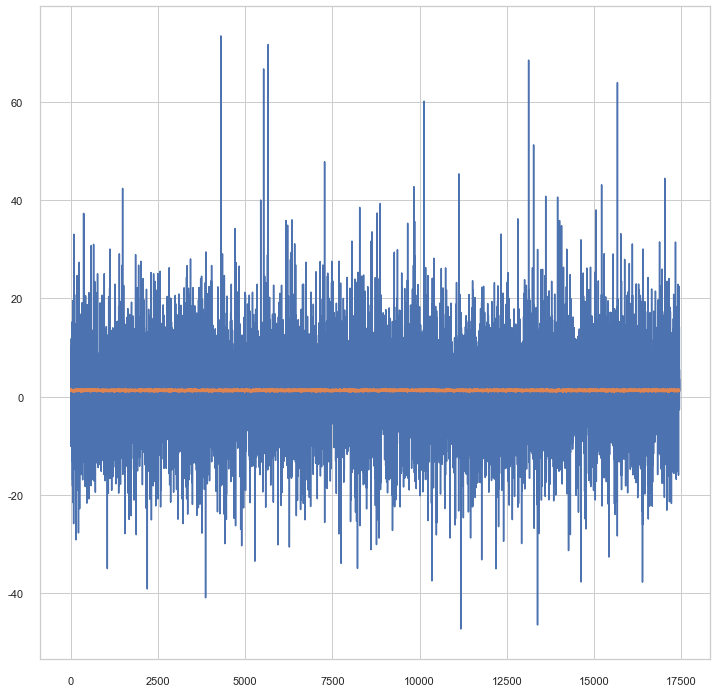

In [20]:
plt.plot(y_test.values.ravel())
plt.plot(y_hat0)

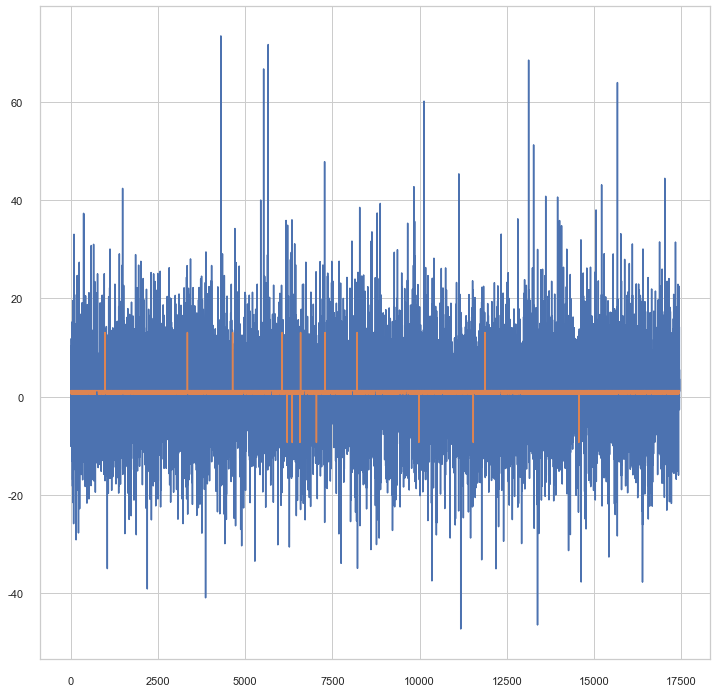

In [22]:
plt.plot(y_test.values.ravel())
plt.plot(y_hat1)

## Intertability

### Partial Dependance Plot

In [25]:
regr.fit(X_train,y_train)
print(sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names[:6]), reverse=True))

[(0.2524, 'EMA6'), (0.2209, 'ROE'), (0.1342, 'ev_ebitda'), (0.1177, 'Asset Turnover'), (0.1118, 'earningsVol'), (0.0959, 'PS')]


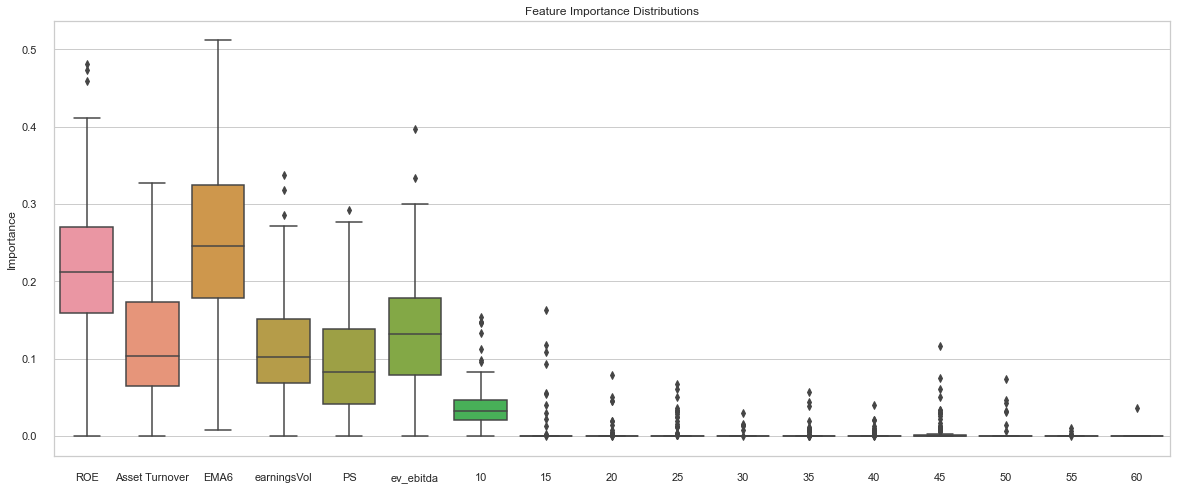

In [28]:
import seaborn as sns
p["figure.figsize"] = [20, 8]
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     regr],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

### Feature Importance

#### Mean Decrease Impurity

In [31]:
import eli5
from eli5.sklearn import PermutationImportance
feat_imp_df = eli5.explain_weights_df(reg, feature_names=feature_names)
feat_imp_df

Using TensorFlow backend.


,target,feature,weight
0,y,<BIAS>,1.186667
1,y,45,0.169543
2,y,35,0.130378
3,y,20,0.093501
4,y,ev_ebitda,0.080125
5,y,ROE,0.025984
6,y,30,0.017724
7,y,Asset Turnover,0.013019
8,y,50,0.001381
9,y,40,-0.004244


#### Permutation Importance

In [34]:
perm = PermutationImportance(reg, random_state=1).fit(X_test, y_test)
#feature_names = feature_names.astype(str)
for i in range(0, len(feature_names)): 
    feature_names[i] = str(feature_names[i]) 
      
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
0.0012 ± 0.0002,10
0.0003 ± 0.0002,45
0.0001 ± 0.0001,ev_ebitda
0.0001 ± 0.0001,Asset Turnover
0.0000 ± 0.0002,35
0.0000 ± 0.0001,PS
0.0000 ± 0.0000,EMA6
0.0000 ± 0.0000,55
0.0000 ± 0.0000,50
0 ± 0.0000,15


[(0.2524, 'EMA6'), (0.2209, 'ROE'), (0.1342, 'ev_ebitda'), (0.1177, 'Asset Turnover'), (0.1118, 'earningsVol'), (0.0959, 'PS')]


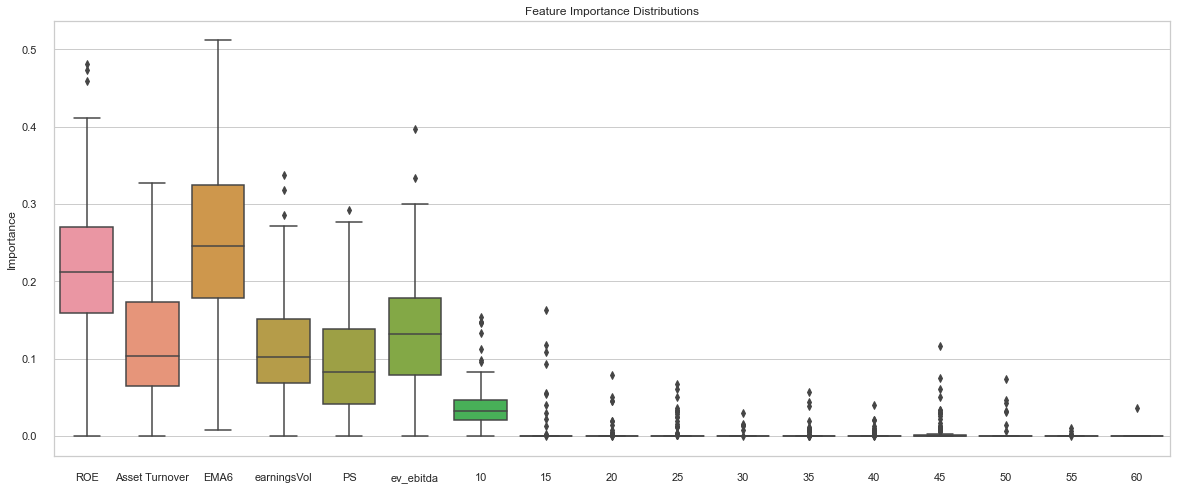

In [36]:
regr.fit(X_train,y_train)
print(sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names[:6]), reverse=True))
import seaborn as sns
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     regr],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

#### ICE

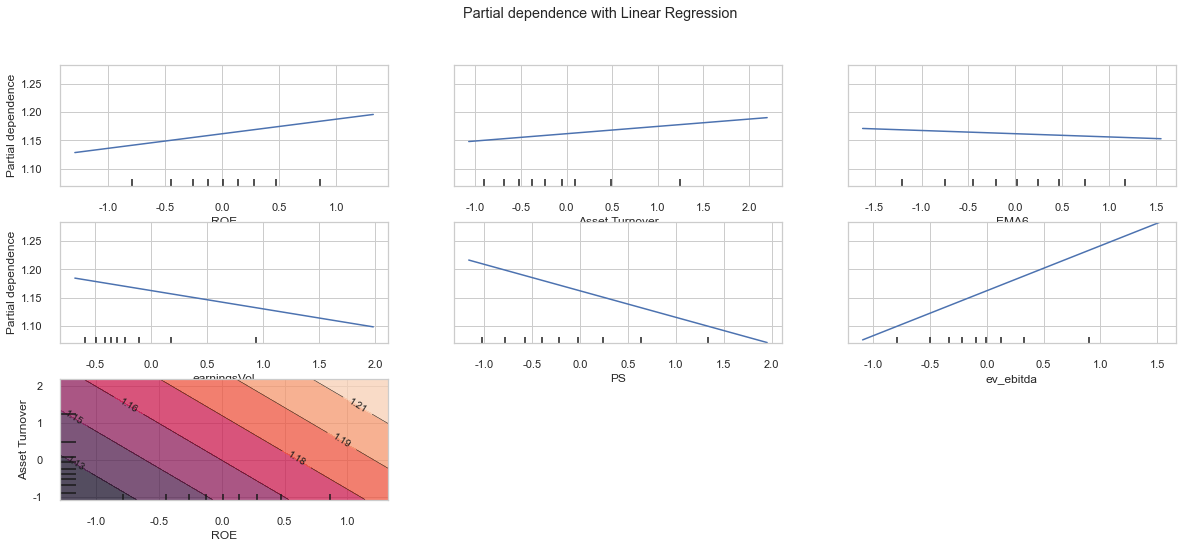

In [56]:
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from matplotlib import pyplot as plt
feature_names=['ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda',10,15,20,25,30,35,40,45,50,55,60]

features = list(range(6))
features.append((0,1))

plot_partial_dependence(reg, X_train, features, feature_names=feature_names[:6]) 
fig = plt.gcf()
fig.suptitle('Partial dependence with Linear Regression')
fig.subplots_adjust(hspace=0.3)